In [17]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Load CSVs
customers = pd.read_csv("C:/Users/Manish/Desktop/Insurance Claim/data/customers (1).csv")
policies = pd.read_csv("C:/Users/Manish/Desktop/Insurance Claim/data/policies.csv")
claims = pd.read_csv("C:/Users/Manish/Desktop/Insurance Claim/data/claims.csv")
external_data = pd.read_csv("C:/Users/Manish/Desktop/Insurance Claim/data/external_data.csv")

# Quick check
##print(customers.shape, policies.shape, claims.shape, external_data.shape)
print(claims.head())
#print(policies.head())
#print(external_data.head())
print(customers.head())





  claim_id policy_id claim_type partner_id incident_date report_date  \
0   CL0001     P4673      Motor      PR090    2023-11-05  2023-11-10   
1   CL0002     P3803   Property      PR125    2023-06-07  2023-06-16   
2   CL0003     P2912      Motor      PR060    2023-11-18  2023-11-30   
3   CL0004     P0669     Health      PR062    2023-05-07  2023-06-05   
4   CL0005     P1271      Motor      PR031    2023-07-22  2023-08-17   

   sum_insured   claim_amount  is_fraud  
0       921680  995226.437257         0  
1       442660  331220.348758         0  
2       701820  722858.883183         0  
3       118440  109342.067370         0  
4       761019  420829.177986         0  
  customer_id  age  gender       city  income  past_claims  \
0       C0001   58  Female  Bangalore  100825            1   
1       C0002   48    Male    Chennai   81574            2   
2       C0003   34    Male    Kolkata  115548            0   
3       C0004   62  Female  Bangalore   48812            1   
4    

In [21]:


#  Merge claims + policies ---
merged_df = claims.merge(
    policies, on="policy_id", how="left", suffixes=("_claim", "_policy")
)

# Merge with customers ---
merged_df = merged_df.merge(customers, on="customer_id", how="left")

# --- Step 3: Merge with external data ---
merged_df = merged_df.merge(
    external_data, on="partner_id", how="left", suffixes=("", "_external")
)

# Drop duplicate columns 
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

print("✅ Final shape:", merged_df.shape)
merged_df.head(3)
merged_df.to_csv("C:/Users/Manish/Desktop/Insurance Claim/data/merged_df.csv")


✅ Final shape: (5000, 25)


In [20]:


import pandas as pd
import numpy as np

# Load your current dataset
#merged_df = pd.read_csv("C:/Users/Manish/Desktop/Insurance Claim/data/merged_df.csv")

# Convert dates
for col in ["incident_date", "report_date"]:
    merged_df[col] = pd.to_datetime(merged_df[col], errors='coerce')

# --- 1. Make some fraud cases look genuine ---
fraud_idx = merged_df[merged_df["is_fraud"] == 1].sample(frac=0.3, random_state=42).index
merged_df.loc[fraud_idx, "claim_to_sum_ratio"] = merged_df.loc[fraud_idx, "claim_to_sum_ratio"] * np.random.uniform(0.4, 0.9, len(fraud_idx))
merged_df.loc[fraud_idx, "report_delay_days"] = merged_df.loc[fraud_idx, "report_delay_days"] * np.random.uniform(0.3, 0.8, len(fraud_idx))

# --- 2. Make some genuine cases look suspicious ---
nonfraud_idx = merged_df[merged_df["is_fraud"] == 0].sample(frac=0.05, random_state=42).index
merged_df.loc[nonfraud_idx, "claim_to_sum_ratio"] = merged_df.loc[nonfraud_idx, "claim_to_sum_ratio"] * np.random.uniform(1.5, 3.5, len(nonfraud_idx))
merged_df.loc[nonfraud_idx, "report_delay_days"] = merged_df.loc[nonfraud_idx, "report_delay_days"] * np.random.uniform(1.5, 2.5, len(nonfraud_idx))

# --- 3. Add data quality noise ---
# Randomly drop city or partner info
for col in ["city", "partner_id"]:
    if col in merged_df.columns:
        merged_df.loc[merged_df.sample(frac=0.1).index, col] = np.nan

# --- 4. Add random missing numerical data ---
for col in ["premium", "sum_insured", "claim_amount"]:
    merged_df.loc[merged_df.sample(frac=0.03).index, col] = np.nan

# --- 5. Random label noise ---
flip_idx = merged_df.sample(frac=0.01, random_state=42).index
merged_df.loc[flip_idx, "is_fraud"] = 1 - merged_df.loc[flip_idx, "is_fraud"]

# Save updated noisy dataset
merged_df.to_csv("C:/Users/Manish/Desktop/Insurance Claim/data/merged_df_realistic_noisy.csv", index=False)

print("✅ Realistic noisy dataset created successfully!")
print("Shape:", merged_df.shape)
print("Fraud ratio:", merged_df['is_fraud'].mean())


KeyError: 'claim_to_sum_ratio'

In [5]:
# Basic info
merged_df.info()

# Summary stats
merged_df.describe(include='all').T

# Missing values
missing = merged_df.isnull().mean().sort_values(ascending=False)
print("Missing value percentage:\n", missing[missing > 0])


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   claim_id             5000 non-null   object 
 1   policy_id            5000 non-null   object 
 2   claim_type           5000 non-null   object 
 3   partner_id           5000 non-null   object 
 4   incident_date        5000 non-null   object 
 5   report_date          5000 non-null   object 
 6   sum_insured_claim    5000 non-null   int64  
 7   claim_amount         4808 non-null   float64
 8   is_fraud             5000 non-null   int64  
 9   customer_id          5000 non-null   object 
 10  policy_type          5000 non-null   object 
 11  start_date           5000 non-null   object 
 12  end_date             5000 non-null   object 
 13  premium              4800 non-null   float64
 14  sum_insured_policy   5000 non-null   float64
 15  age                  5000 non-null   i

Outlier claims (claim_amount > sum_insured): 1076


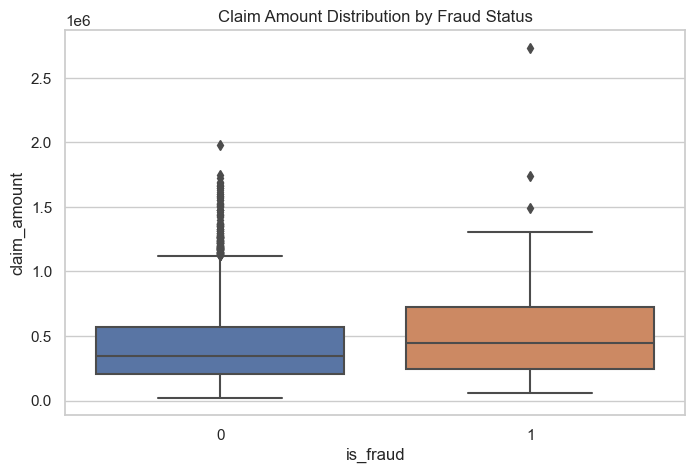

In [6]:
# Claims higher than sum insured
outliers = merged_df[merged_df["claim_amount"] > merged_df["sum_insured_policy"]]
print(f"Outlier claims (claim_amount > sum_insured): {len(outliers)}")

# Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(data=merged_df, x="is_fraud", y="claim_amount")
plt.title("Claim Amount Distribution by Fraud Status")
plt.show()


In [7]:
merged_df["claim_exceeds_sum_insured"] = (merged_df["claim_amount"] > merged_df["sum_insured_policy"]).astype(int)
merged_df["claim_exceeds_sum_insured"].value_counts()

merged_df.groupby("claim_exceeds_sum_insured")["is_fraud"].mean()


claim_exceeds_sum_insured
0    0.026249
1    0.059480
Name: is_fraud, dtype: float64

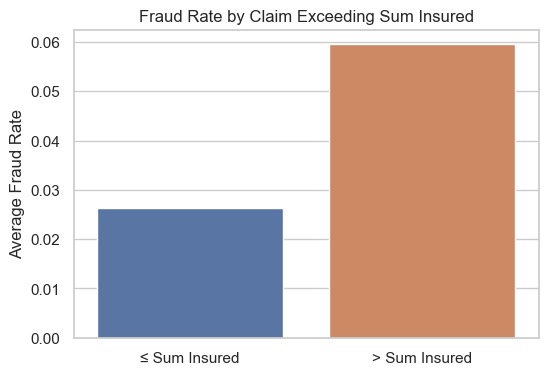

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fraud_rate = merged_df.groupby("claim_exceeds_sum_insured")["is_fraud"].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x="claim_exceeds_sum_insured", y="is_fraud", data=fraud_rate)
plt.xticks([0,1], ["≤ Sum Insured", "> Sum Insured"])
plt.title("Fraud Rate by Claim Exceeding Sum Insured")
plt.ylabel("Average Fraud Rate")
plt.xlabel("")
plt.show()


In [10]:
merged_df[["is_fraud", "claim_exceeds_sum_insured"]].corr()


,is_fraud,claim_exceeds_sum_insured
is_fraud,1.000000,0.076006
claim_exceeds_sum_insured,0.076006,1.000000


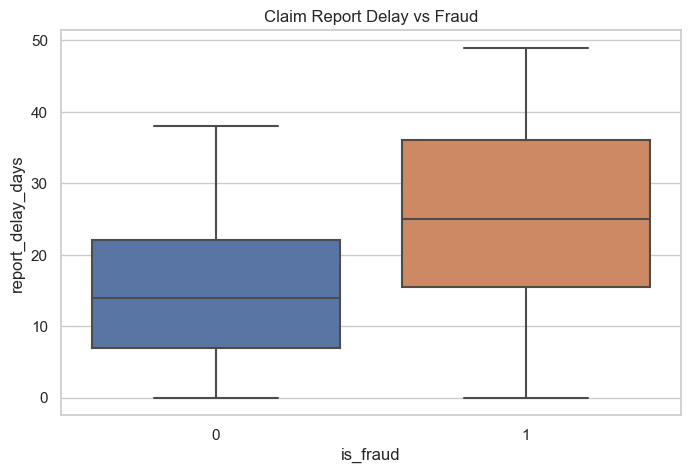

In [11]:
merged_df["incident_date"] = pd.to_datetime(merged_df["incident_date"])
merged_df["report_date"] = pd.to_datetime(merged_df["report_date"])
merged_df["report_delay_days"] = (merged_df["report_date"] - merged_df["incident_date"]).dt.days

# Summary
merged_df["report_delay_days"].describe()

# Plot delay by fraud status
plt.figure(figsize=(8,5))
sns.boxplot(data=merged_df, x="is_fraud", y="report_delay_days")
plt.title("Claim Report Delay vs Fraud")
plt.show()


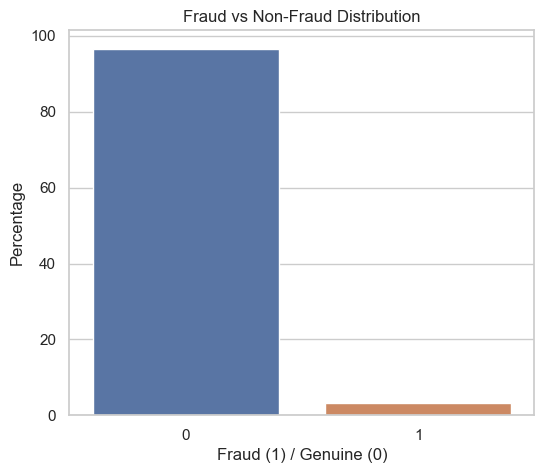

0    96.66
1     3.34
Name: is_fraud, dtype: float64


In [12]:
plt.figure(figsize=(6,5))
fraud_counts = merged_df["is_fraud"].value_counts(normalize=True) * 100
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title("Fraud vs Non-Fraud Distribution")
plt.xlabel("Fraud (1) / Genuine (0)")
plt.ylabel("Percentage")
plt.show()

print(fraud_counts)


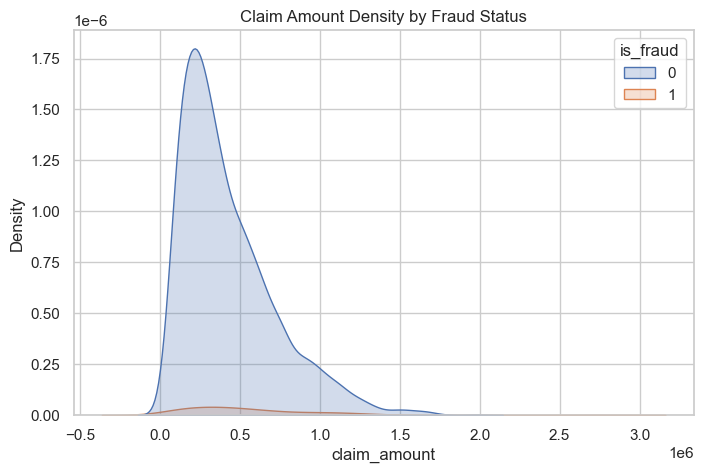

In [13]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=merged_df, x="claim_amount", hue="is_fraud", fill=True)
plt.title("Claim Amount Density by Fraud Status")
plt.show()


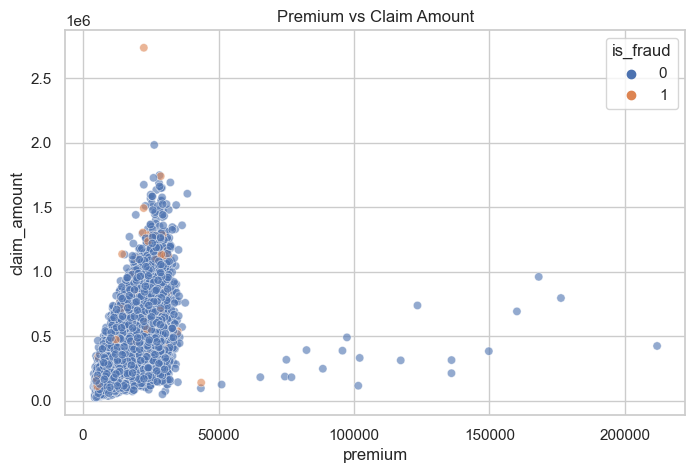

In [14]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=merged_df, x="premium", y="claim_amount", hue="is_fraud", alpha=0.6)
plt.title("Premium vs Claim Amount")
plt.show()


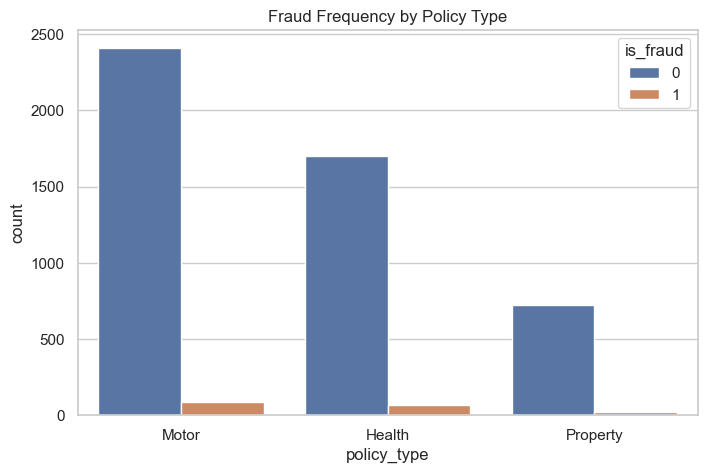

In [15]:
plt.figure(figsize=(8,5))
sns.countplot(data=merged_df, x="policy_type", hue="is_fraud")
plt.title("Fraud Frequency by Policy Type")
plt.show()


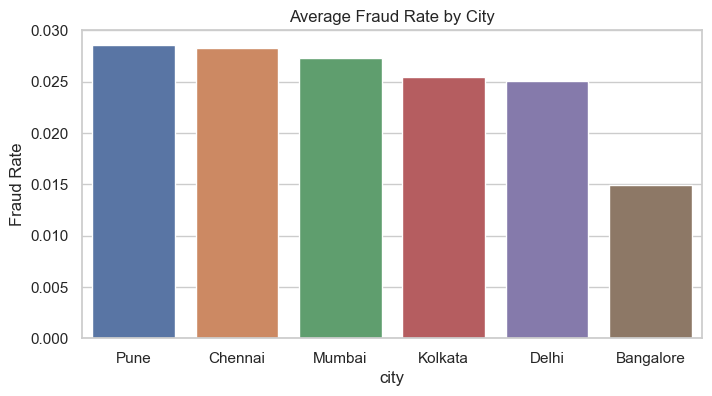

In [62]:
fraud_city = merged_df.groupby("city")["is_fraud"].mean().sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=fraud_city.index, y=fraud_city.values)
plt.title("Average Fraud Rate by City")
plt.ylabel("Fraud Rate")
plt.show()
